In [32]:
import pandas as pd
import json
import nltk
from nltk.corpus import stopwords
import methods
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import numpy as np
from matplotlib.pyplot import MultipleLocator
nltk.download('stopwords')
path = '/Users/merlin/Desktop/BA/Bachelorabeit Uni Leipzig/programming/dhox/data'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/merlin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Read token/year/embedding into df
data = pd.read_csv(path+"/1950-60_timestamps_wYear.csv")

In [4]:
all_years = set(data['year'].unique())
all_years

{1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959}

In [5]:
#filter stopwords and words that occure in every year
tokens_in_all_years_unfilterd = (
    data.groupby('token')['year']
      .nunique()  # number of unique years per token
      .eq(len(all_years))  # equals total number of years in dataset?
)
tokens_in_all_years = tokens_in_all_years_unfilterd[tokens_in_all_years_unfilterd.values]
#keywords = "professor", "teaching", "work", "equality", "authority", "cultural"
stop_words = set(stopwords.words('english'))
df_filtered = data[-data['token'].isin(stop_words)]
df_filtered = df_filtered[df_filtered['token'].notna()]
df_filtered = df_filtered[df_filtered['token'].str.isalnum()]
df_filtered = df_filtered[df_filtered['token'].isin(tokens_in_all_years.keys())]
df_filtered = df_filtered[data['token'].str.len() > 1]  

/var/folders/jb/jz3xgqts0zx_lxl_9ylrxrv80000gn/T/ipykernel_12318/3601829585.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[data['token'].str.len() > 1]


In [6]:
# Averaging the embeddings per year, but loosing the year column
df_filtered_avg = pd.DataFrame()
for _ in all_years:
    df_year = df_filtered[df_filtered["year"]==_]
    df_year = methods.average_token_embeddings(df_year)
    df_filtered_avg = pd.concat([df_filtered_avg, df_year])

In [7]:
df_filtered_avg

,year,token,Unnamed: 0,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,1952,1948,127158.645161,0.228583,-0.093119,0.138831,0.194837,0.001755,-0.224450,0.331547,...,-0.409262,0.208141,-0.446709,-0.015345,0.004620,-0.075236,-0.331296,-0.597654,-0.133964,0.040565
1,1952,address,108351.500000,-0.314434,0.552629,-0.219903,-0.297742,-0.074961,0.264401,0.154629,...,-0.206937,-0.238267,0.447002,-0.336573,0.173233,-0.453993,0.189267,-0.088822,-0.107714,0.328007
2,1952,attempt,106690.142857,-0.241588,0.574166,0.062378,-0.179115,0.648157,0.554260,0.350589,...,-0.106114,-0.160326,-0.112712,0.101436,0.037203,-0.217117,-0.069245,-0.170097,0.034886,-0.268247
3,1952,attention,120098.062500,-0.128066,0.494089,0.273731,0.020918,0.052956,0.054859,-0.254287,...,-0.095627,-0.123445,0.138930,-0.360137,0.071926,-0.140746,-0.425897,0.165899,0.085589,-0.443958
4,1952,author,98395.120000,-0.638096,0.621188,0.334642,-0.348412,0.306512,-0.405279,-0.157788,...,-0.030628,-0.382768,-0.642278,-0.038691,-0.131152,-0.204301,-0.317836,-0.001923,-0.060383,-0.705342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,1951,used,54875.717647,-0.161202,0.403663,0.088356,0.086146,0.031451,-0.015919,0.012692,...,-0.418293,-0.059614,-0.176585,-0.316514,-0.190897,-0.452504,-0.305535,-0.222100,0.117927,0.073711
67,1951,using,58844.179487,-0.167027,0.441560,0.008974,0.081954,-0.131179,0.101591,0.148178,...,-0.387067,-0.098703,-0.313515,-0.195425,0.120785,-0.619343,0.034388,-0.170641,0.036582,0.032212
68,1951,war,41908.900000,0.026966,0.314592,0.098794,-0.112196,0.089413,0.093167,0.340827,...,0.232852,-0.073926,0.409733,-0.230871,0.123923,0.165421,-0.194323,0.083883,-0.243496,0.051156
69,1951,whole,56939.162162,-0.106401,-0.115172,0.304529,-0.033829,-0.460195,0.012492,0.113594,...,0.017174,0.121408,0.471954,-0.238138,-0.176984,-0.020653,-0.035392,-0.107173,0.066805,-0.347006


In [8]:
df_input = df_filtered_avg.sort_values(['token', 'year'])
df_input[50:100]

,year,token,Unnamed: 0,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
5,1950,available,5026.333333,-0.608350,0.093171,0.132099,0.121948,0.477547,-0.094653,0.063761,...,-0.325693,-0.455187,0.359866,-0.357848,-0.327718,-0.423807,-0.069365,0.060498,-0.178044,0.135580
5,1951,available,53205.666667,-0.611541,0.117711,0.401931,0.020726,0.342863,-0.032441,0.097690,...,-0.323912,-0.206844,0.107905,-0.257235,-0.558275,-0.579848,-0.193707,0.047339,0.018275,0.058465
5,1952,available,114289.189189,-0.555993,0.103958,0.382716,-0.002727,0.356021,-0.017123,0.075533,...,-0.318521,-0.248526,0.091533,-0.231990,-0.557540,-0.568872,-0.157021,0.072788,0.033003,0.037846
5,1953,available,180063.666667,-0.528476,0.166153,0.290014,0.042390,0.245533,-0.000647,0.117182,...,-0.338032,-0.185461,0.079522,-0.109504,-0.562183,-0.629145,-0.224283,0.021737,0.058378,0.018115
5,1954,available,250751.066667,-0.516954,0.083655,0.332174,-0.025127,0.435157,-0.067866,0.124806,...,-0.360930,-0.366407,0.171368,-0.063478,-0.447536,-0.458381,-0.028247,0.100478,0.018052,0.043320
5,1955,available,299832.700000,-0.553757,0.120554,0.371908,-0.036492,0.350166,-0.124969,0.053277,...,-0.259167,-0.164628,-0.090067,-0.217851,-0.462503,-0.499853,-0.108627,0.102945,0.127064,-0.136405
5,1956,available,366309.877358,-0.508678,0.076802,0.349622,0.065352,0.405012,-0.041364,0.051693,...,-0.336491,-0.290185,0.090053,-0.155559,-0.489690,-0.507362,-0.134010,0.062923,0.049093,0.023612
5,1957,available,451313.000000,-0.391763,0.167243,0.209297,0.298515,0.420948,-0.141984,-0.220189,...,-0.097896,0.184448,-0.148359,-0.375195,-0.585004,-0.477069,-0.164395,-0.121030,0.219089,0.179048
5,1958,available,464721.833333,-0.671214,0.149091,0.363165,-0.027886,0.231859,-0.037438,0.013187,...,-0.211740,-0.246682,0.141228,-0.229442,-0.450579,-0.524104,-0.117272,0.115851,0.133576,-0.046692
5,1959,available,503581.785714,-0.536377,0.114856,0.343598,0.179350,0.446030,-0.050643,-0.002478,...,-0.299411,-0.110107,0.191906,-0.291272,-0.714027,-0.507113,-0.215457,0.032477,0.050126,0.107204


In [9]:
set(df_input['token'])

{'1948',
 'address',
 'attempt',
 'attention',
 'author',
 'available',
 'background',
 'circumstances',
 'college',
 'con',
 'data',
 'department',
 'des',
 'distribution',
 'economic',
 'education',
 'en',
 'expressed',
 'government',
 'gr',
 'income',
 'individual',
 'information',
 'instance',
 'labor',
 'li',
 'library',
 'light',
 'little',
 'living',
 'longer',
 'making',
 'many',
 'material',
 'might',
 'must',
 'office',
 'op',
 'opinions',
 'order',
 'part',
 'policy',
 'population',
 'presented',
 'private',
 'problem',
 'professor',
 'reading',
 'receive',
 'reference',
 'relative',
 'rep',
 'required',
 'respect',
 'review',
 'service',
 'specific',
 'state',
 'states',
 'statistical',
 'students',
 'sub',
 'title',
 'treatment',
 'understanding',
 'united',
 'used',
 'using',
 'war',
 'whole',
 'within'}

In [86]:
keywords = "professor", "education", "government", "income", "labor"
years = sorted(list(all_years))

type(years[0])

numpy.int64

0
1952
1
1953
2
1954
3
1955
4
1956
5
1957
6
1958
7
1959
8
1950
9
1951
0
1952
1
1953
2
1954
3
1955
4
1956
5
1957
6
1958
7
1959
8
1950
9
1951


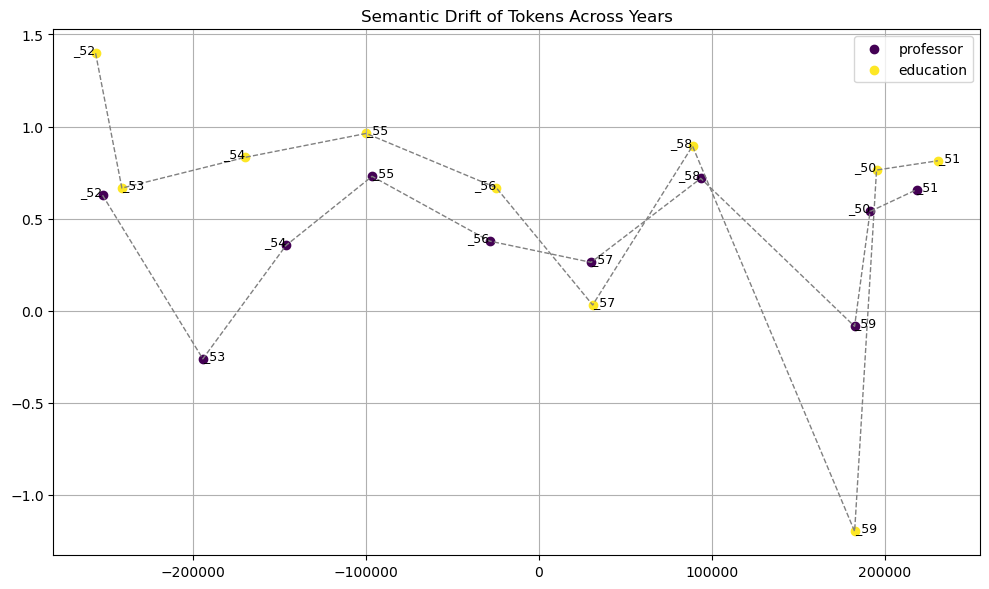

In [88]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import numpy as np

# Step 1: Select target tokens
keywords = "professor", "education"

# Step 2: Filter the DataFrame for these tokens
df_input


# Step 3: Sort by token and year to maintain consistent order
df_subset = df_input.sort_values(['token', 'year']).reset_index(drop=True)

# Step 4: Extract embeddings columns (all except 'year' and 'token')
embedding_cols = [c for c in df_subset.columns if c not in ['year', 'token']]
embeddings = df_subset[embedding_cols].values

# Step 5: Reduce dimensionality
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Step 6: Prepare plotting
years = all_years
n_tokens = len(keywords)
n_years = len(years)
colors = cm.viridis(np.linspace(0, 1, n_tokens))

plt.figure(figsize=(10, 6))

# Step 7: Plot points and lines for semantic drift
for i, token in enumerate(keywords):
    token_rows = df_subset[df_subset['token'] == token]
    coords = reduced[token_rows.index, :]  # get PCA-reduced coordinates

    # Scatter points
    for j, year in enumerate(years):
        print(j), print(year)
        x, y = coords[j]
        plt.scatter(x, y, color=colors[i], label=str(token) if j == 0 else "")
        plt.text(x, y, f"_{str(year)[-2:]}", fontsize=9,
                 ha='right' if j % 2 == 0 else 'left')

    # Connect points across years
    plt.plot(coords[:, 0], coords[:, 1], color='gray', linestyle='--', linewidth=1)

# reordering the labels


plt.title("Semantic Drift of Tokens Across Years")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
keywords = "professor", "education", "government", "income", "labor"
df_distances = pd.DataFrame()
df_keyword = df_input[df_input["token"] == "professor"]
df_keyword2 = df_input[df_input["token"] == "education"]
df_keyword3 = df_input[df_input["token"] == "government"]
df_keyword4 = df_input[df_input["token"] == "income"]
df_keyword5 = df_input[df_input["token"] == "labor"]
df_keyword



,year,token,Unnamed: 0,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
20,1950,income,11629.000000,-0.187757,0.270107,0.283332,-0.149113,0.123656,-0.086861,0.228750,...,0.115193,-0.506991,0.623741,-0.072186,0.179427,-0.297095,-0.140423,-0.156619,0.004299,-0.380522
20,1951,income,43652.500000,-0.380999,-0.165101,0.325016,-0.113678,0.456937,0.324937,-0.068577,...,0.042796,-0.136927,0.645460,0.000109,0.202041,-0.559273,-0.293349,-0.116277,-0.063630,-0.028732
20,1952,income,102436.500000,-0.422679,-0.220232,0.373339,-0.105907,0.377518,0.231809,0.053117,...,0.024555,-0.060251,0.682286,0.005991,0.223549,-0.499765,-0.329025,-0.029207,0.049822,-0.336955
20,1953,income,175784.000000,-0.283961,-0.050230,0.276804,-0.046892,0.370463,0.210799,0.015751,...,-0.049012,-0.078574,0.536819,0.067236,0.301819,-0.394013,-0.189383,-0.101940,-0.000498,-0.127051
20,1954,income,238203.000000,-0.452003,-0.080019,0.159432,-0.123072,0.294812,0.201628,-0.209619,...,0.003578,-0.324756,0.492961,-0.086604,0.171368,-0.419713,-0.299843,-0.198450,0.148080,-0.750268
20,1955,income,302423.750000,-0.334711,0.321373,0.083839,-0.031863,0.309931,0.349039,0.072060,...,-0.130805,-0.131597,0.398917,0.157532,-0.040714,-0.359872,-0.309086,-0.163062,-0.247081,-0.029437
20,1956,income,362575.600000,-0.352314,0.043116,0.284209,-0.036446,0.269864,0.133423,-0.012418,...,-0.034066,-0.131792,0.517857,0.087560,0.088679,-0.383698,-0.235464,-0.126569,0.091086,-0.339432
20,1957,income,451294.000000,-0.188682,0.116957,0.105788,0.134900,0.526759,0.393542,-0.050148,...,0.165771,-0.216205,0.558791,0.128590,0.032992,-0.441048,-0.043859,-0.352987,0.048590,-0.412816
20,1958,income,468893.250000,-0.558936,0.069261,0.204791,-0.160462,0.394836,0.193377,-0.031267,...,-0.196521,0.003343,0.493776,0.042130,0.140955,-0.513614,-0.269172,-0.037997,0.040836,-0.518835
20,1959,income,498774.086957,-0.591883,-0.120755,0.286710,-0.099300,0.351355,-0.018520,-0.106914,...,0.065137,-0.071171,0.615455,-0.062324,-0.211624,-0.583557,-0.224627,-0.180836,0.020219,-0.184853


In [73]:
df_distances = pd.DataFrame()
df_distances = pd.concat([df_distances, methods.compute_distances_single_df(df_keyword)])
df_distances2 = methods.compute_distances_single_df(df_keyword2)
df_distances3 = methods.compute_distances_single_df(df_keyword3)
df_distances4 = methods.compute_distances_single_df(df_keyword4)
df_distances5 = methods.compute_distances_single_df(df_keyword5)



Processing row 47professor
Processing row 47professor
Processing row 47professor
Processing row 47professor
Processing row 47professor
Processing row 47professor
Processing row 47professor
Processing row 47professor
Processing row 47professor
Processing row 47professor
Processing row 16education
Processing row 16education
Processing row 16education
Processing row 16education
Processing row 16education
Processing row 16education
Processing row 16education
Processing row 16education
Processing row 16education
Processing row 16education
Processing row 19government
Processing row 19government
Processing row 19government
Processing row 19government
Processing row 19government
Processing row 19government
Processing row 19government
Processing row 19government
Processing row 19government
Processing row 19government
Processing row 21income
Processing row 21income
Processing row 21income
Processing row 21income
Processing row 21income
Processing row 21income
Processing row 21income
Processing r

In [75]:
df_distances3


,token,distance
0,government,1.000000
1,government,0.818960
2,government,0.924747
3,government,0.917427
4,government,0.905541
5,government,0.816896
6,government,0.931970
7,government,0.708385
8,government,0.884092
9,government,0.942144


In [77]:
df_distances['years']= sorted(list(all_years))
df_distances2['years']= sorted(list(all_years))
df_distances3['years']= sorted(list(all_years))
df_distances4['years']= sorted(list(all_years))
df_distances5['years']= sorted(list(all_years))
df_distances2

,token,distance,years
0,education,1.000000,1950
1,education,0.949918,1951
2,education,0.967258,1952
3,education,0.973497,1953
4,education,0.953058,1954
5,education,0.927185,1955
6,education,0.965796,1956
7,education,0.782183,1957
8,education,0.943151,1958
9,education,0.936964,1959


In [1]:
# create token -> distance df, by going through the df filtering by list of keywords #
df_distances = pd.DataFrame()
for keyword in keywords:
    df_keyword = df_input[df_input["token"] == keyword]
    df_distances = pd.concat([df_distances, methods.compute_distances_single_df(df_keyword)])


NameError: name 'pd' is not defined

<Figure size 640x480 with 0 Axes>

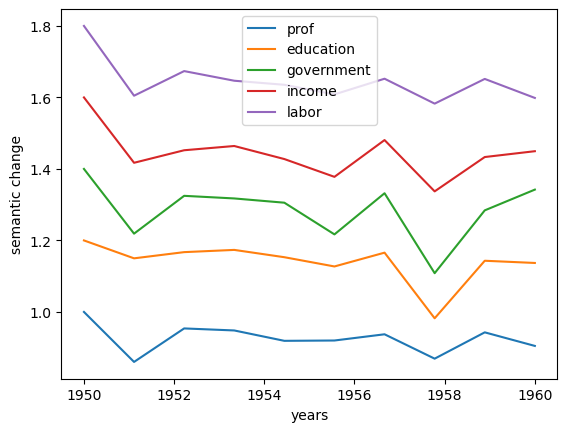

In [81]:
fig = plt.figure()  
fig, ax = plt.subplots()  
ax.set_xlabel("years")
x = np.linspace(1950, 1960, 10)
ax.set_ylabel("semantic change")
y = df_distances['distance']
ax.plot(x,y,label='prof')
g = df_distances2['distance']
ax.plot(x,g+0.2,label='education')
h = df_distances3['distance']
ax.plot(x,h+0.4,label='government')
j = df_distances4['distance']
ax.plot(x,j+0.6,label='income')
k = df_distances5['distance']
ax.plot(x,k+0.8,label='labor')
ax.legend()
